In [65]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import tensorflow as tf
import numpy as np
import os
import scipy.io 
from matplotlib import pyplot as plt
import cv2
%matplotlib inline 

In [66]:
n_classes = 31
# using the fine-tuned Inception V3 model
base_model = load_model('model.h5')

In [67]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [68]:
# Extract features from dense_1 layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('dense_1').output)

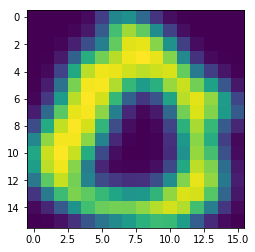

In [69]:
# load in the usps data from the local file
data_dict = scipy.io.loadmat("usps_resampled.mat") 
# Visualize the import, making sure its OK 
test_data = data_dict['train_patterns'][:, 1]
plt.imshow(np.reshape(test_data, [16, 16]))

In [70]:
# using purely the training data and label should be ample for our experiment
usps_data = data_dict['train_patterns'].T
usps_label = data_dict['train_labels'].T
print (usps_label.shape)
print (usps_data.shape)
print (usps_label[:5])

(4649, 10)
(4649, 256)
[[-1 -1 -1 -1 -1 -1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [71]:
# Preprocess the label
n_data = usps_label.shape[0]
n_classes = usps_label.shape[1]
for i in range(n_data):
    for j in range(n_classes):
        if usps_label[i][j] == -1:
            usps_label[i][j] = 0

In [72]:
print (usps_label[:5])

[[0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


In [73]:
# We also need to adjust the shape of the image
# First reshape the data
usps_data_1 = np.reshape(usps_data, [usps_data.shape[0], 16, 16, 1])
# next gave it depth of 3
usps_data_2 = usps_data_1/3
usps_data_3 = np.concatenate((usps_data_2, usps_data_2, usps_data_2), axis = 3)
usps_data_3.shape

(4649, 16, 16, 3)

In [75]:
# lastly, resize the data to match the network
def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 140, 140, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

n_samples = 2000
n_classes = 10
usps_data_upscaled = resize_data(usps_data_3)
usps_data_upscaled_selected = usps_data_upscaled[:n_samples]
usps_labels_selected = usps_label[:n_samples]

# Final Check - before Feature extraction
print (usps_data_upscaled_selected.shape)
print (usps_labels_selected.shape)

(2000, 140, 140, 3)
(2000, 10)


In [77]:
# Feature Extraction
usps_features = model.predict(usps_data_upscaled_selected)
usps_features.shape

(2000, 1024)

In [78]:
# according to Dr. Shay Deutsch's matlab code, the shape should be (Dimension, # of Sample)
usps_features = usps_features.T

In [80]:
# save it to .mat file
import scipy.io
scipy.io.savemat('USPS_fine_tuned_inceptionV3_by_MNIST.mat', mdict={"USPS": usps_features})

In [28]:
#########################################################
## You can run from here if the denoising is completed ##
#########################################################

import scipy.io
import numpy as np
dic = scipy.io.loadmat('USPS_fine_tuned_inceptionV3_by_MNIST.mat')
usps_features = dic['USPS'].T
dic = scipy.io.loadmat('USPS_denoised.mat')
usps_denoised = dic['feats_denoised'].T

# Also need labels for visualization
data_dict = scipy.io.loadmat("usps_resampled.mat") 
n_samples = 2000
usps_label = data_dict['train_labels'].T[:n_samples]
# Preprocess the label
n_data = usps_label.shape[0]
n_classes = usps_label.shape[1]
for i in range(n_data):
    for j in range(n_classes):
        if usps_label[i][j] == -1:
            usps_label[i][j] = 0
            
print (usps_label[:5])

[[0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


In [29]:
# Need to change the one-hot encoding of label to normal one
usps_label_normal = []
for i in range(usps_label.shape[0]):
    for j in range(usps_label.shape[1]):
        if usps_label[i][j] == 1:
            usps_label_normal.append(j)
usps_label_normal = np.array(usps_label_normal)
usps_label_normal[:10]

array([6, 0, 1, 2, 0, 0, 6, 3, 8, 8])

In [30]:
# Let's sort the sample according to its labels 
usps_label_sorted = []
usps_features_sorted = []
usps_denoise_sorted = []
for i in range(10):
    for j in range(len(usps_label_normal)):
        if usps_label_normal[j] == i:
            usps_label_sorted.append(i)
            usps_features_sorted.append(list(usps_features[j]))
            usps_denoise_sorted.append(list(usps_denoised[j]))

usps_label_sorted = np.array(usps_label_sorted)
usps_features_sorted = np.array(usps_features_sorted)
usps_denoise_sorted = np.array(usps_denoise_sorted)

In [31]:
#TODO: use the sorted matrix as input to the matlab algorithm 
#TODO: Check the Affinity Matrix 
#TODO: Implement the cosine distance function in matlab 
#TODO: Implement the RBF kernel for measure of distance 

(2000, 1024)

In [10]:
# visualize the noisy data using PCA & t-SNE
# Quote Shay: "apply t-SNE only may be better"
# Apply PCA 
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(usps_features)

print ('Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Explained variation per principal component (PCA): 0.891802966594696


In [11]:
# Apply t-SNE
n_sne = usps_features.shape[0] #use all the data

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(pca_result_50[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.401425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.242233
[t-SNE] Error after 500 iterations: 1.098416
t-SNE done! Time elapsed: 36.8932249546051 seconds


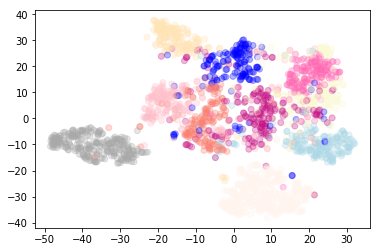

In [16]:
# visualize it
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
color = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
list_of_col = []
for col in color: 
    list_of_col.append(col)
colors = list_of_col[:10]


tsne_one = tsne_pca_results[:, 0]
tsne_two = tsne_pca_results[:, 1]
plt.scatter(x = tsne_one[:n_sne], y = tsne_two[:n_sne], c = usps_label_normal[:n_sne], cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3) 

In [18]:
# now visualize the denoised feature
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(usps_denoised)

print ('Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Explained variation per principal component (PCA): 0.9027076862665081


In [19]:
# Apply t-SNE
n_sne = usps_denoised.shape[0] #use all the data

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(pca_result_50[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.006s...
[t-SNE] Computed neighbors for 2000 samples in 0.399s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.165098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.500999
[t-SNE] Error after 500 iterations: 1.054460
t-SNE done! Time elapsed: 33.11407494544983 seconds


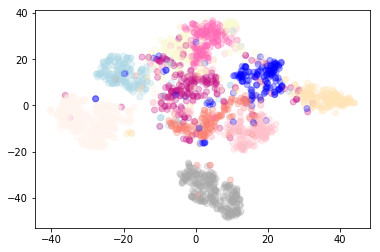

In [20]:
# visualize it

tsne_one = tsne_pca_results[:, 0]
tsne_two = tsne_pca_results[:, 1]
plt.scatter(x = tsne_one[:n_sne], y = tsne_two[:n_sne], c = usps_label_normal[:n_sne], cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.100s...
[t-SNE] Computed neighbors for 2000 samples in 7.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.839469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.272156
[t-SNE] Error after 500 iterations: 1.118490
t-SNE done! Time elapsed: 274.51287293434143 seconds


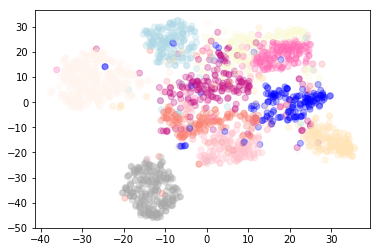

In [21]:
# Now we just do t-SNE, as Dr. Deutsch suggested
# First, noisy data
ime_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(usps_features[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_one = tsne_pca_results[:, 0]
tsne_two = tsne_pca_results[:, 1]
plt.scatter(x = tsne_one[:n_sne], y = tsne_two[:n_sne], c = usps_label_normal[:n_sne], cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.119s...
[t-SNE] Computed neighbors for 2000 samples in 8.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.553214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.540665
[t-SNE] Error after 500 iterations: 1.077663
t-SNE done! Time elapsed: 322.87845492362976 seconds


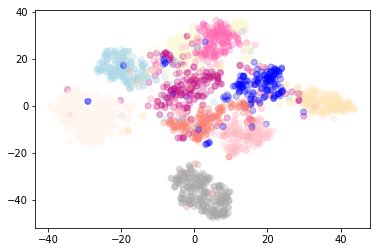

In [22]:
# Now we just do t-SNE, as Dr. Deutsch suggested
# Next, denoised data
ime_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(usps_denoised[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_one = tsne_pca_results[:, 0]
tsne_two = tsne_pca_results[:, 1]
plt.scatter(x = tsne_one[:n_sne], y = tsne_two[:n_sne], c = usps_label_normal[:n_sne], cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3) 